In [192]:
import numpy as np 
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

import sys
sys.path.append('../scripts/') 

from aux_funcs import label_encoder, load_ct_scans, competition_metric, extract_img_id, get_config, make_ct_git, filter_by_std
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

from tensorflow import keras

config = get_config()
train_df = pd.read_csv(config['data_path']+'/train.csv')
test_df = pd.read_csv(config['data_path']+'/test.csv')
sub_df = pd.read_csv(config['data_path']+'/sample_submission.csv')

In [193]:
def encode_categorical(df):
    sex_encoding = {'Male':0, 'Female':1}
    df.Sex = df.Sex.apply(lambda x: 1 if x == 'Female' else 0)
    df['current_smoker'] = df.SmokingStatus.apply(lambda x: 1 if x == 'Currently smokes' else 0)
    df['ex_smoker'] = df.SmokingStatus.apply(lambda x: 1 if x == 'Ex-smoker' else 0)
    df['never_smoker'] = df.SmokingStatus.apply(lambda x: 1 if x == 'Never smoked' else 0)
    df.drop(['SmokingStatus'],1,inplace=True)

    return df

In [194]:
sub_df['Patient'] = sub_df.Patient_Week.apply(lambda x: x.split('_')[0])
sub_df['Week'] = sub_df.Patient_Week.apply(lambda x: x.split('_')[1])
sub_df.drop(['Patient_Week'], 1, inplace=True)

In [195]:
train_df = encode_categorical(train_df)
test_df = encode_categorical(test_df)

In [196]:
patients_train, patients_test = train_test_split(np.unique(train_df['Patient'].values), test_size=0.3, shuffle=True, random_state=63)

In [197]:
df_train = []
for p in patients_train:
    mask = train_df['Patient'] == p
    df_train.append(train_df.values[mask])
df_train = pd.DataFrame(np.concatenate(df_train, 0), columns=list(train_df.columns))

df_test = []
for p in patients_test:
    mask = train_df['Patient'] == p
    df_test.append(train_df.values[mask])
df_test = pd.DataFrame(np.concatenate(df_test, 0), columns=list(train_df.columns))

In [198]:
# Normalizing data
mu_norm = dict()
std_norm = dict()

for feat in ['Weeks', 'FVC', 'Percent', 'Age']:
    mu_norm[feat], std_norm[feat] = np.mean(df_train[feat].values), np.std(df_train[feat].values)
    df_train[feat] = (df_train[feat].values - mu_norm[feat])/std_norm[feat]
    df_test[feat] = (df_test[feat].values - mu_norm[feat])/std_norm[feat]

In [199]:
pats_train = df_train['Patient'].values
pats_test = df_test['Patient'].values

X_train = df_train.drop(['Patient', 'FVC'], 1)
cols_X = X_train.columns
X_train = X_train.values
Y_train = df_train['FVC'].values
X_test = df_test.drop(['Patient', 'FVC'], 1).values
Y_test = df_test['FVC'].values

Training Error 0.16626416941483793
Test Error 0.24054933152274477


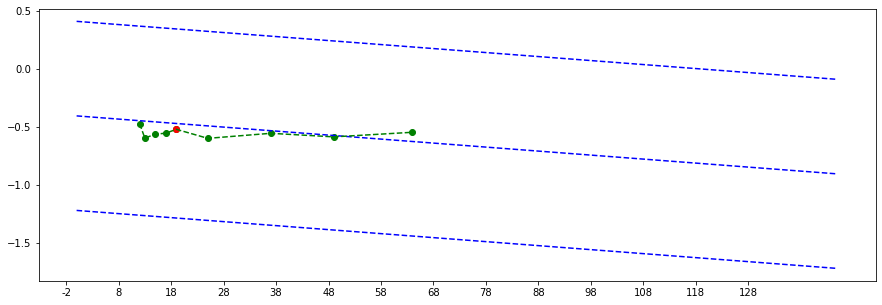

Competition metric -8.488181720301757


In [200]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression(normalize=True, n_jobs=-1)
lin_reg.fit(X_train, Y_train)

print('Training Error', np.mean(np.square(Y_train - lin_reg.predict(X_train))))
print('Test Error', np.mean(np.square(Y_test - lin_reg.predict(X_test))))

std_linreg = np.std(Y_train - lin_reg.predict(X_train))

id_pat = np.random.randint(X_test.shape[0])
X_pred = np.hstack([np.arange(-12,134).reshape(-1,1), np.repeat(X_test[id_pat:id_pat+1, 1:], 146, axis=0)])
linreg_pred = lin_reg.predict(X_pred)

mask = df_test['Patient'] == pats_test[id_pat]
test_vals = df_test[['Patient', 'Weeks', 'FVC']].values[mask,1:]

plt.figure(figsize=(15,5))
plt.plot(linreg_pred, linestyle='--', c='b')
plt.plot(linreg_pred+2*std_linreg, linestyle='--', c='b')
plt.plot(linreg_pred-2*std_linreg, linestyle='--', c='b')

plt.xticks(range(-12,134, 10), range(-12,134, 10))
plt.scatter((test_vals[:,0]*std_norm['Weeks'])+mu_norm['Weeks'], test_vals[:,1], c='g')
plt.plot((test_vals[:,0]*std_norm['Weeks'])+mu_norm['Weeks'], test_vals[:,1], linestyle='--', c='g')

plt.scatter((X_test[id_pat:id_pat+1, 0]*std_norm['Weeks'])+mu_norm['Weeks'], Y_test[id_pat:id_pat+1], c='r')
plt.show()

Y_pred = (lin_reg.predict(X_test)*std_norm['FVC'])+mu_norm['FVC']
Y_true = (Y_test*std_norm['FVC'])+mu_norm['FVC']
sigma = np.ones_like(Y_pred)*((std_linreg*std_norm['FVC'])+mu_norm['FVC'])

print('Competition metric', np.mean(competition_metric(Y_true, Y_pred, sigma)))

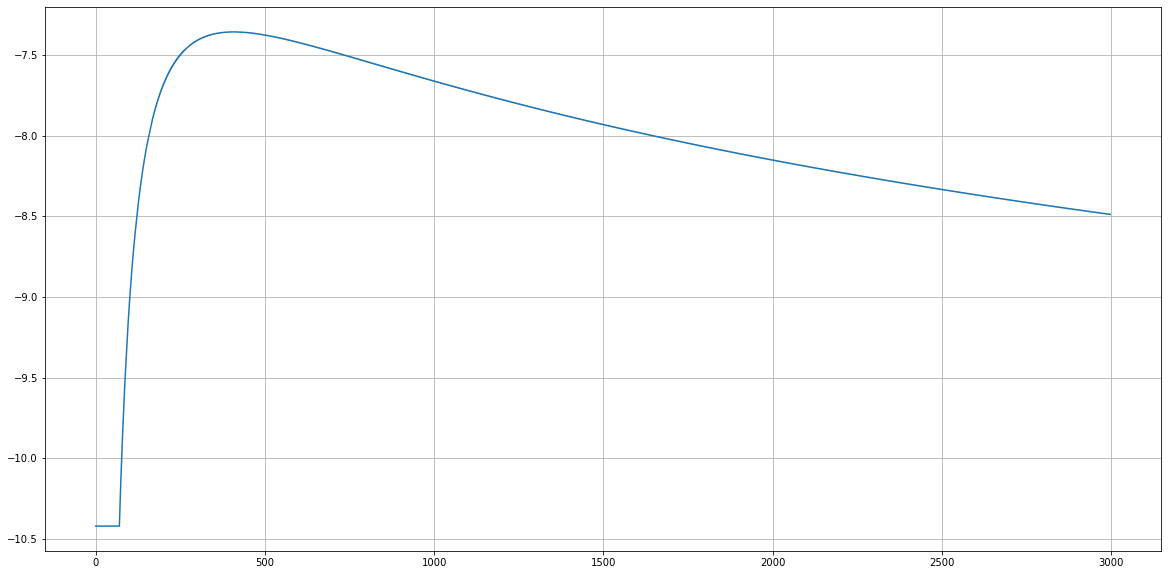

Best alpha 397.7 ; Metric = -7.357


In [201]:
stds_vals, metrics = [], []
for x in np.arange(0,sigma[0], 0.1):
    stds_vals.append(round(x,3))
    metrics.append(round(np.mean(competition_metric(Y_true, Y_pred, x)),3))
plt.figure(figsize=(20,10))
plt.plot(stds_vals, metrics)
plt.grid()
plt.show()
print('Best alpha', stds_vals[np.argmax(metrics)], '; Metric =', metrics[np.argmax(metrics)])

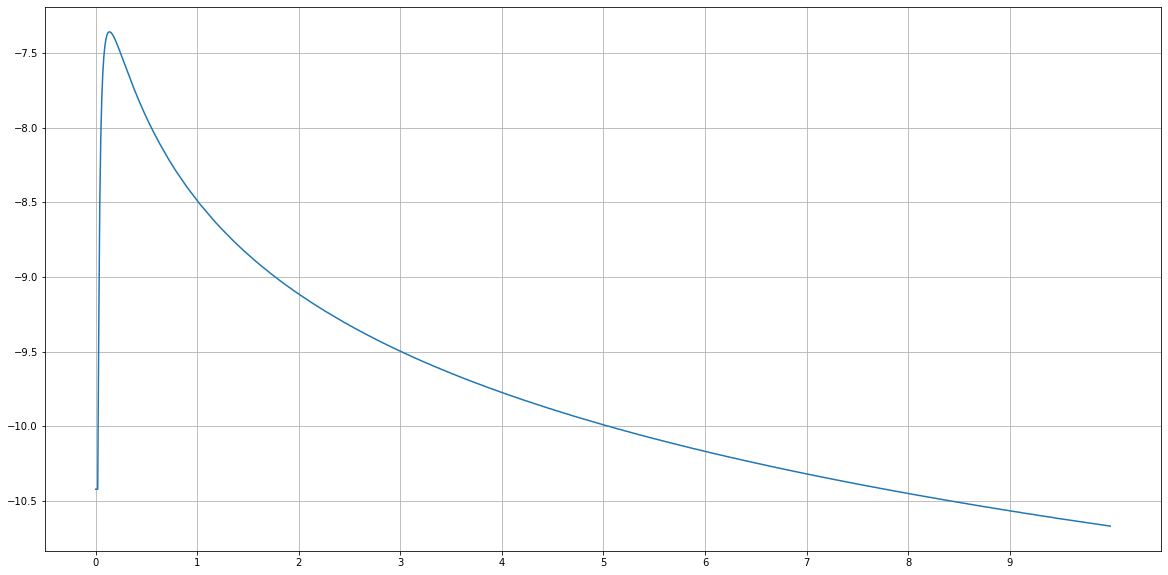

Best alpha 0.13 ; Metric = -7.358


In [202]:
alphas, metrics = [], []
for alpha in np.arange(0,10,0.01):
    alphas.append(round(alpha,3))
    metrics.append(round(np.mean(competition_metric(Y_true, Y_pred, alpha*sigma)),3))
plt.figure(figsize=(20,10))
plt.plot(alphas, metrics)
plt.grid()
plt.xticks(np.arange(0,10), np.arange(0,10))
plt.show()
print('Best alpha', alphas[np.argmax(metrics)], '; Metric =', metrics[np.argmax(metrics)])

In [203]:
# Generate competition submission
opt_alpha = 0.13

submission = []

for i in range(test_df.shape[0]):
    patient = test_df.values[i,0]
    X_pred = test_df[cols_X].iloc[i:i+1,:]

    for feat in ['Weeks', 'Percent', 'Age']:
        X_pred[feat] = (X_pred[feat].values - mu_norm[feat])/std_norm[feat]
    X_pred = X_pred.values.reshape(1,-1)

    X_pred = np.hstack([np.arange(-12,134).reshape(-1,1), np.repeat(X_pred[:, 1:], 146, axis=0)])
    Y_pred = (lin_reg.predict(X_pred)*std_norm['FVC'])+mu_norm['FVC']

    patient_submission = []
    for j, w in enumerate(np.arange(-12,134)):
        vals = np.array([w, patient+'_'+str(w), Y_pred[j], opt_alpha*((std_linreg*std_norm['FVC'])+mu_norm['FVC'])]).reshape(1,-1)
        vals = pd.DataFrame(vals, columns=['Week', 'Patient_Week', 'FVC', 'Confidence'])
        vals['Week'] = vals['Week'].astype(np.int32)
        vals['FVC'] = vals['FVC'].astype(np.float32)
        vals['Confidence'] = vals['Confidence'].astype(np.float32)
        patient_submission.append(vals)
    patient_submission = pd.concat(patient_submission)
    submission.append(patient_submission)

submission = pd.concat(submission)
submission.sort_values('Week', inplace=True)
submission.drop(['Week'], 1, inplace=True)

In [204]:
submission.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2635.400879,389.697754
0,ID00426637202313170790466_-12,2686.270508,389.697754
0,ID00421637202311550012437_-12,3104.972412,389.697754
0,ID00423637202312137826377_-12,2945.825195,389.697754
0,ID00422637202311677017371_-12,2844.972656,389.697754


In [205]:
#submission.to_csv('submission.csv', index=False)